# Dimension Reduction Method

In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from imblearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, roc_curve, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin

In [203]:
# import data
X_train = pd.read_csv('data/X_train.csv')
X_val = pd.read_csv('data/X_val.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_val = pd.read_csv('data/y_val.csv')
y_test = pd.read_csv('data/y_test.csv')

## Correlation Analysis

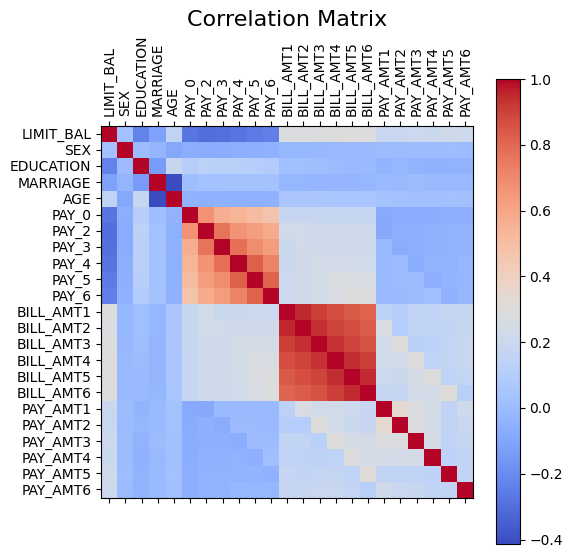

In [204]:
# analyze correlation
corr = X_train.corr()
plt.figure(figsize=(6, 6))
plt.matshow(corr, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

As shown from the correlation matrix, some variables are highly correlated and can negatively impact the performance and interpretability of prediction models. Therefore, we explore dimension reduction methods to:
- Reduce multicollinearity among predictors;
- Improve computational efficiency;
- Enhance model generalization on unseen data; and
- Enable better data visualization and interpretation.

## Principal Component Analysis

Principal Component Analysis (PCA) is an unsupervised linear transformation technique that transforms the original variables into a new set of uncorrelated variables called principal components. These components are ordered by the amount of variance they capture from the data:
- The first principal component explains the maximum possible variance.
- Each subsequent component explains the remaining variance orthogonal to the previous ones.

Given a standardized feature matrix $ X\in R^{n \times p} $, PCA finds a projection $Z=X \times W$, where $W$ is the matrix of eigenvectors corresponding to the top eigenvalues of the covariance matrix of $X$.

In [205]:
# Apply PCA
pca = PCA()  
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

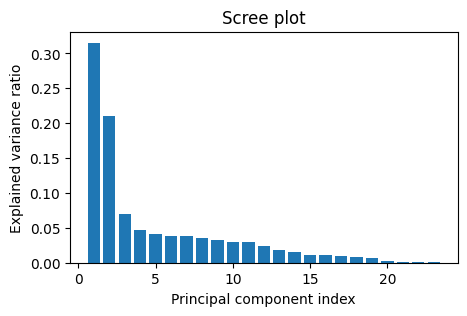

In [206]:
# Scree plot
plt.figure(figsize=(5, 3))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.title('Scree plot')
plt.show()

An elbow is seen after the first two principal components.

In [207]:
# Explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_[:2])

Explained variance ratio: [0.31536077 0.20972532]


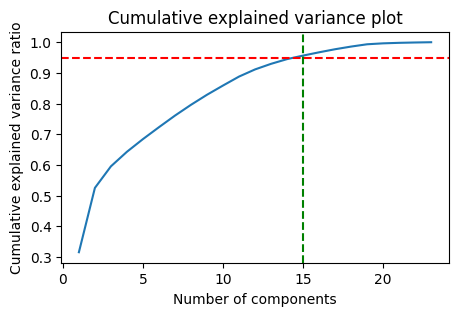

In [208]:
# plot cumulative explained variance
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.title('Cumulative explained variance plot')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axvline(x=15, color='g', linestyle='--')
plt.show()

The first 15 components explain more than 95% of the variance. 

### Visualization

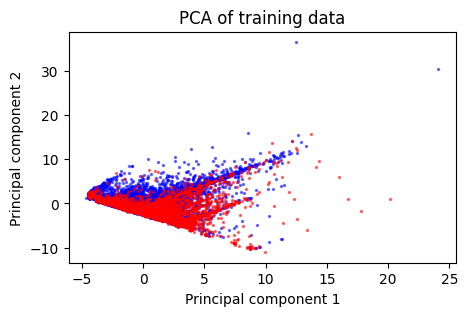

In [209]:
a = y_train.iloc[:,0].values

# Plot the PCA results
plt.figure(figsize=(5, 3))
plt.scatter(X_train_pca[a == 0, 0], X_train_pca[a == 0, 1], color='blue', alpha=0.5, s=2)
plt.scatter(X_train_pca[a == 1, 0], X_train_pca[a == 1, 1], color='red', alpha=0.5, s=2)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('PCA of training data')
plt.show()

The two groups seem to have large overlap when there are only two principal components. 

## Principal Component Regression

Principal Component Regression (PCR) combines PCA with linear regression. Instead of regressing the response variable (e.g., credit default outcome) directly on the original predictors, PCR involves:
- Applying PCA to the predictor matrix $X$ to obtain a set of principal components.
- Selecting the top $k$ components that explain a sufficient proportion of the variance.
- Fitting a regression model using these $K$ components as predictors.

This method helps to address multicollinearity and reduce overfitting, especially when $p>n$ or when many predictors are highly correlated.

Advantages of PCR:
- Reduces dimensionality while retaining key information.
- Handles multicollinearity effectively.
- Improves model interpretability when visualizing principal components.

Limitations:
- PCA is unsupervised and does not consider the response variable in its decomposition.
- Important variables for prediction may be underrepresented in the top components if they do not explain large variance.

### Baseline

In [210]:
# perform logistic regression with PCA on validation set
lr_baseline = LogisticRegression(class_weight={0: 1, 1: 20})
lr_baseline.fit(X_train_pca[:,:15], a)
y_pred_baseline_pca = lr_baseline.predict(X_val_pca[:,:15])
print("Logistic Regression classification report:\n", classification_report(y_val.iloc[:,0].values, y_pred_baseline_pca))

Logistic Regression classification report:
               precision    recall  f1-score   support

           0       0.95      0.01      0.02      4673
           1       0.22      1.00      0.36      1327

    accuracy                           0.23      6000
   macro avg       0.59      0.51      0.19      6000
weighted avg       0.79      0.23      0.10      6000



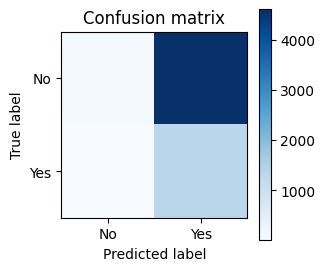

In [211]:
def plot_cm(cm):
    plt.figure(figsize=(3, 3))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.xticks(np.arange(2), ['No', 'Yes'])
    plt.yticks(np.arange(2), ['No', 'Yes'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Confusion matrix
cm_baseline = confusion_matrix(y_val.iloc[:,0].values, y_pred_baseline_pca)
plot_cm(cm_baseline)

### Cross-Validation to Determine Optimal Number of Components

In predicting credit default, false negatives (failing to predict an actual default) are more costly than false positives. Since standard accuracy metrics don't account for the asymmetric costs, we'll:
- Create a custom scoring function that heavily penalizes false negatives
- Use class weights to make the model more sensitive to defaults
- Consider precision-recall metrics that focus on the positive class

In [212]:
def fn_penalized_score(y_true, y_pred, fn_cost=5, fp_cost=1):
    """Custom score that heavily penalizes false negatives"""
    cm = confusion_matrix(y_true, y_pred)
    fn = cm[1, 0]  # False negatives
    fp = cm[0, 1]  # False positives
    total_cost = fn * fn_cost + fp * fp_cost
    return -total_cost  # Return negative for GridSearchCV maximization

custom_scorer = make_scorer(fn_penalized_score)

In [213]:
# Create imbalanced pipeline with PCA -> Logistic Regression
pipeline_pca = make_pipeline(
    PCA(),
    LogisticRegression(
        class_weight={0: 1, 1: 20},
        max_iter=1000,
        random_state=42
    )
)

# Parameter grid for GridSearch
param_grid_pca = {
    'pca__n_components': [2, 5, 8, 11, 14, 17, 20, 23],  # Number of principal components
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],  # Regularization
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],  # Regularization types
    'logisticregression__solver': ['liblinear', 'saga']  # solvers for l1 and l2
}

# Stratified KFold maintains class balance in splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search with custom scoring
grid_pca = GridSearchCV(
    pipeline_pca,
    param_grid_pca,
    cv=skf,
    scoring=custom_scorer,
    n_jobs=-1,
    verbose=1
)
grid_pca.fit(X_train, y_train.iloc[:,0].values)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


c:\Users\65835\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
400 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\65835\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\65835\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\65835\AppData\Local\Programs\Python\Python39\lib\site-package

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('logisticregression',
                                        LogisticRegression(class_weight={0: 1,
                                                                         1: 20},
                                                           max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
                         'logisticregression__penalty': ['l1', 'l2',
                                                         'elasticnet'],
                         'logisticregression__solver': ['liblinear', 'saga'],
                         'pca__n_components': [2, 5, 8, 11, 14, 17, 20, 23]},
             scoring=make_scorer(fn_penalized_score, response_method='predict'),
             verbose=1)

In [214]:
# Get results
best_model_pca = grid_pca.best_estimator_
best_n_components_pca = grid_pca.best_params_['pca__n_components']
print("Best model:", best_model_pca)
print("Best number of components:", best_n_components_pca)

Best model: Pipeline(steps=[('pca', PCA(n_components=20)),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight={0: 1, 1: 20},
                                    max_iter=1000, random_state=42,
                                    solver='liblinear'))])
Best number of components: 20


In [215]:
# Get predicted probabilities for threshold adjustment
y_proba = cross_val_predict(
    best_model_pca,
    X_train,
    y_train.iloc[:, 0].values,
    cv=skf,
    method='predict_proba',
    n_jobs=-1
)[:, 1]  # Probabilities for class 1 (default)

# Find optimal threshold that minimizes our cost function
thresholds = np.linspace(0.1, 0.9, 50)
costs_pca = []

for thresh in thresholds:
    preds = (y_proba > thresh).astype(int)
    cost = fn_penalized_score(y_train.iloc[:,0].values, preds)
    costs_pca.append(cost)

optimal_threshold_pca = thresholds[np.argmax(costs_pca)]
print("Optimal threshold:", optimal_threshold_pca)

Optimal threshold: 0.8510204081632654


### Best Model

In [216]:
X_train_cv_pca = best_model_pca[0].fit_transform(X_train)
X_val_cv_pca = best_model_pca[0].transform(X_val)
lr_cv = best_model_pca[1]
lr_cv.fit(X_train_cv_pca, a)
y_pred_cv_proba = lr_cv.predict_proba(X_val_cv_pca)
y_pred_cv_pca = (y_pred_cv_proba[:, 1] > optimal_threshold_pca).astype(int)
print("Validation set classification report:\n", classification_report(y_val.iloc[:,0].values, y_pred_cv_pca))

Validation set classification report:
               precision    recall  f1-score   support

           0       0.86      0.74      0.80      4673
           1       0.39      0.59      0.47      1327

    accuracy                           0.71      6000
   macro avg       0.63      0.66      0.63      6000
weighted avg       0.76      0.71      0.72      6000



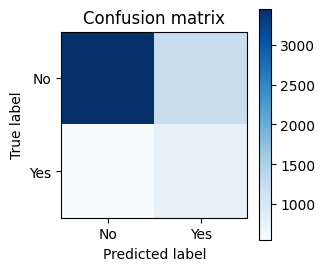

In [217]:
# Confusion matrix for validation set
cm_cv = confusion_matrix(y_val.iloc[:,0].values, y_pred_cv_pca)
plot_cm(cm_cv)

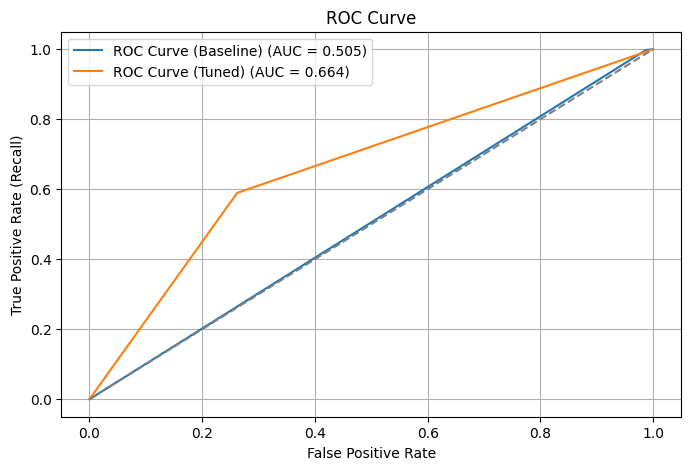

In [218]:
# Compute ROC
fpr_baseline, tpr_baseline, _ = roc_curve(y_val.iloc[:,0].values, y_pred_baseline_pca)
auc_score_baseline = roc_auc_score(y_val.iloc[:,0].values, y_pred_baseline_pca)

fpr_cv, tpr_cv, _ = roc_curve(y_val.iloc[:,0].values, y_pred_cv_pca)
auc_score_cv = roc_auc_score(y_val.iloc[:,0].values, y_pred_cv_pca)

# Plot ROC
plt.figure(figsize=(8, 5))
plt.plot(fpr_baseline, tpr_baseline, label=f"ROC Curve (Baseline) (AUC = {auc_score_baseline:.3f})")
plt.plot(fpr_cv, tpr_cv, label=f"ROC Curve (Tuned) (AUC = {auc_score_cv:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

When compared to other models like LASSO, Ridge Regression, or tree-based models (e.g., Random Forest, XGBoost), PCR may not always yield the best performance due to its unsupervised nature. However, it serves as a robust baseline, especially useful for exploratory analysis or in scenarios with high multicollinearity.

A comparative analysis might reveal:
- PCR performs well in reducing overfitting when predictors are numerous and correlated.
- Supervised methods like Partial Least Squares Regression (PLSR) or regularized models may outperform PCR when the focus is strictly on predictive accuracy.

## Partial Least Squares Regression

Partial Least Squares (PLS) is a statistical method used for modeling relationships between predictor variables (X) and response variables (Y). It is particularly useful in scenarios where predictors are highly collinear or when the number of predictors exceeds the number of observations—common challenges in credit risk modeling. PLS reduces dimensionality by projecting both X and Y into a new latent variable space, maximizing the covariance between them.

PLS operates through the following key steps:

1. Latent Variable Extraction: 
    - PLS identifies latent components (also called factors or projections) that explain the maximum covariance between predictors (e.g., financial ratios, credit history) and the response variable (e.g., default status).
    - Unlike Principal Component Analysis (PCA), which only considers variance in X, PLS incorporates the relationship between X and Y.

2. Iterative Weight Calculation:
    - Weights are computed to create linear combinations of predictors that best explain the response.
    - The algorithm iteratively refines these weights to improve prediction accuracy.

3. Regression on Latent Components:
    - A linear regression model is built using the extracted latent components rather than the original predictors, mitigating multicollinearity.

In [233]:
# Apply Partial Least Squares (PLS)
pls = PLSRegression()
X_train_pls, y_train_pls = pls.fit_transform(X_train, y_train)
X_val_pls, y_val_pls = pls.transform(X_val, y_val)

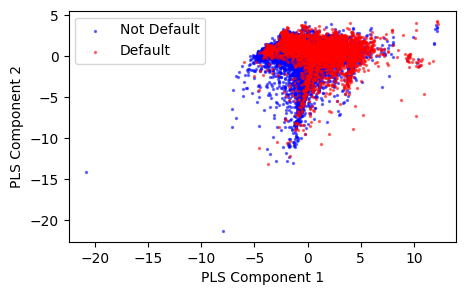

In [234]:
# Plot the PLS results
plt.figure(figsize=(5, 3))
plt.scatter(X_train_pls[a == 0, 0], X_train_pls[a == 0, 1], color='blue', label='Not Default', alpha=0.5, s=2)
plt.scatter(X_train_pls[a == 1, 0], X_train_pls[a == 1, 1], color='red', label='Default', alpha=0.5, s=2)
plt.xlabel('PLS Component 1')
plt.ylabel('PLS Component 2')
plt.legend()
plt.show()

### Baseline

In [235]:
lr_baseline.fit(X_train_pls, a)
y_pred_baseline_pls = lr_baseline.predict(X_val_pls)
print("Logistic Regression classification report:\n", 
      classification_report(y_val.iloc[:,0].values, y_pred_baseline_pls))

Logistic Regression classification report:
               precision    recall  f1-score   support

           0       0.90      0.01      0.01      4673
           1       0.22      1.00      0.36      1327

    accuracy                           0.23      6000
   macro avg       0.56      0.50      0.19      6000
weighted avg       0.75      0.23      0.09      6000



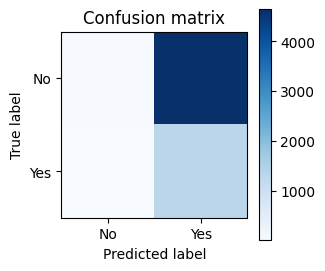

In [236]:
# Confusion matrix
cm_baseline_pls = confusion_matrix(y_val.iloc[:,0].values, y_pred_baseline_pls)
plot_cm(cm_baseline_pls)

### Cross-Validation to Determine Optimal Number of Components

In [223]:
class PLSForClassification(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.pls = PLSRegression(n_components=n_components)
    
    def fit(self, X, y):
        self.pls.fit(X, y)
        return self
    
    def transform(self, X):
        return self.pls.transform(X)

# Create imbalanced pipeline with PCA -> Logistic Regression
pipeline_pls = make_pipeline(
    PLSForClassification(),
    LogisticRegression(
        class_weight={0: 1, 1: 20},
        max_iter=1000,
        random_state=42
    )
)

In [224]:
# Parameter grid for GridSearch
param_grid_pls = {
    'plsforclassification__n_components': [2, 5, 8, 11, 14, 17, 20, 23],  # Number of principal components
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],  # Regularization
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'saga']  # solvers for l1 and l2
}

# Stratified KFold maintains class balance in splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search with custom scoring
grid_pls = GridSearchCV(
    pipeline_pls,
    param_grid_pls,
    cv=skf,
    scoring=custom_scorer,
    n_jobs=-1,
    verbose=1
)
grid_pls.fit(X_train, y_train.iloc[:,0].values)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('plsforclassification',
                                        PLSForClassification()),
                                       ('logisticregression',
                                        LogisticRegression(class_weight={0: 1,
                                                                         1: 20},
                                                           max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear', 'saga'],
                         'plsforclassification__n_components': [2, 5, 8, 11, 14,
                                                                17, 20, 23]},
             scoring=make_scorer(fn_penalized_score, response_method='predict'),
             verbose=1)

In [225]:
# Get results
best_model_pls = grid_pls.best_estimator_
best_n_components_pls = grid_pls.best_params_['plsforclassification__n_components']
print("Best model:", best_model_pls)
print("Best number of components:", best_n_components_pls)

Best model: Pipeline(steps=[('plsforclassification', PLSForClassification()),
                ('logisticregression',
                 LogisticRegression(C=0.001, class_weight={0: 1, 1: 20},
                                    max_iter=1000, random_state=42,
                                    solver='liblinear'))])
Best number of components: 2


In [227]:
# Get predicted probabilities for threshold adjustment
y_proba = cross_val_predict(
    best_model_pls,
    X_train,
    y_train.iloc[:, 0].values,
    cv=skf,
    method='predict_proba',
    n_jobs=-1
)[:, 1]

# Find optimal threshold that minimizes our cost function
thresholds_pls = np.linspace(0.1, 0.9, 50)
costs_pls = []

for thresh in thresholds:
    preds = (y_proba > thresh).astype(int)
    cost = fn_penalized_score(y_train.iloc[:,0].values, preds)
    costs_pls.append(cost)

optimal_threshold_pls = thresholds_pls[np.argmax(costs_pls)]
print("Optimal threshold:", optimal_threshold_pls)

Optimal threshold: 0.8510204081632654


### Best Model

In [229]:
X_train_cv_pls = best_model_pls[0].fit_transform(X_train, a)
X_val_cv_pls = best_model_pls[0].transform(X_val)
lr_cv_pls = best_model_pls[1]
lr_cv_pls.fit(X_train_cv_pls, a)
y_pred_cv_proba_pls = lr_cv_pls.predict_proba(X_val_cv_pls)
y_pred_cv_pls = (y_pred_cv_proba_pls[:, 1] > optimal_threshold_pls).astype(int)
print("Validation set classification report:\n", classification_report(y_val.iloc[:,0].values, y_pred_cv_pls))

Validation set classification report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      4673
           1       0.43      0.51      0.47      1327

    accuracy                           0.74      6000
   macro avg       0.64      0.66      0.65      6000
weighted avg       0.76      0.74      0.75      6000



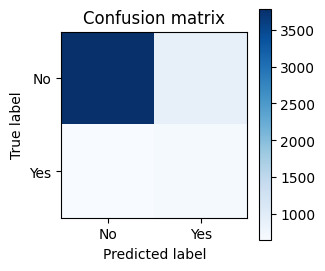

In [230]:
# Confusion matrix for validation set
cm_cv_pls = confusion_matrix(y_val.iloc[:,0].values, y_pred_cv_pls)
plot_cm(cm_cv_pls)

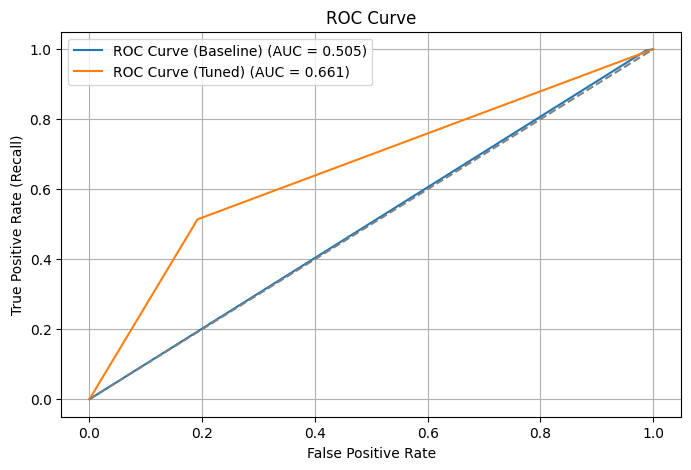

In [231]:
# Compute ROC
fpr_baseline, tpr_baseline, _ = roc_curve(y_val.iloc[:,0].values, y_pred_baseline_pls)
auc_score_baseline = roc_auc_score(y_val.iloc[:,0].values, y_pred_baseline_pls)

fpr_cv, tpr_cv, _ = roc_curve(y_val.iloc[:,0].values, y_pred_cv_pls)
auc_score_cv = roc_auc_score(y_val.iloc[:,0].values, y_pred_cv_pls)

# Plot ROC
plt.figure(figsize=(8, 5))
plt.plot(fpr_baseline, tpr_baseline, label=f"ROC Curve (Baseline) (AUC = {auc_score_baseline:.3f})")
plt.plot(fpr_cv, tpr_cv, label=f"ROC Curve (Tuned) (AUC = {auc_score_cv:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

Advantages of PLS in Credit Default Prediction
- **Handles Multicollinearity**: PLS is robust to correlated predictors (e.g., income, debt-to-income ratio, credit utilization), which are common in financial datasets.
- **Works with High-Dimensional Data**: Effective when the number of predictors (e.g., hundreds of financial features) exceeds the number of observations.
- **Reduces Overfitting**: By focusing on the most predictive latent components, PLS avoids modeling noise.
- **Interpretability**: Although latent variables are abstract, their contributions to the model can be analyzed for insights.

Limitations of PLS
- **Complexity in Interpretation**: Unlike logistic regression, PLS components are not directly tied to original variables, making explanations less intuitive.
- **Requires Careful Tuning**: The number of latent components must be selected carefully (e.g., via cross-validation) to avoid underfitting or overfitting.
- **Performance Trade-offs**: While PLS handles collinearity well, it may not outperform more flexible machine learning models (e.g., Random Forest, XGBoost) in some cases.

## Comparison

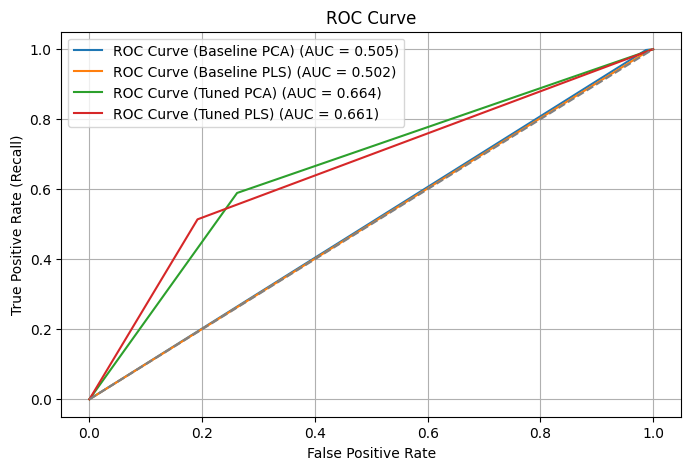

In [237]:
# Compute ROC
fpr_baseline_pca, tpr_baseline_pca, _ = roc_curve(y_val.iloc[:,0].values, y_pred_baseline_pca)
auc_score_baseline_pca = roc_auc_score(y_val.iloc[:,0].values, y_pred_baseline_pca)

fpr_baseline_pls, tpr_baseline_pls, _ = roc_curve(y_val.iloc[:,0].values, y_pred_baseline_pls)
auc_score_baseline_pls = roc_auc_score(y_val.iloc[:,0].values, y_pred_baseline_pls)

fpr_cv_pca, tpr_cv_pca, _ = roc_curve(y_val.iloc[:,0].values, y_pred_cv_pca)
auc_score_cv_pca = roc_auc_score(y_val.iloc[:,0].values, y_pred_cv_pca)

fpr_cv_pls, tpr_cv_pls, _ = roc_curve(y_val.iloc[:,0].values, y_pred_cv_pls)
auc_score_cv_pls = roc_auc_score(y_val.iloc[:,0].values, y_pred_cv_pls)

# Plot ROC
plt.figure(figsize=(8, 5))
plt.plot(fpr_baseline_pca, tpr_baseline_pca, label=f"ROC Curve (Baseline PCA) (AUC = {auc_score_baseline_pca:.3f})")
plt.plot(fpr_baseline_pls, tpr_baseline_pls, label=f"ROC Curve (Baseline PLS) (AUC = {auc_score_baseline_pls:.3f})")
plt.plot(fpr_cv_pca, tpr_cv_pca, label=f"ROC Curve (Tuned PCA) (AUC = {auc_score_cv_pca:.3f})")
plt.plot(fpr_cv_pls, tpr_cv_pls, label=f"ROC Curve (Tuned PLS) (AUC = {auc_score_cv_pls:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()